In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy.interpolate import interp1d

from astropy.table import Table
from scipy.optimize import curve_fit
from pathlib import Path

In [2]:
infile = Path("/home/suman/tifr/202307011_1531_Eu_on_det1_30000pkts.fits")
detid = 1
pha_bins = np.arange(0, 2200, 1)


In [3]:
#detnames = {4:8, 16:9, 5:12, 17:13, 0:"junk"}

In [4]:
def cgauss(x, mean, amp, sigma, const):
    """
    Return const + gaussian
    """
    return const + amp * np.exp( -0.5 * ((x - mean) / sigma)**2 )


In [5]:
def pha2en(pha, gain, offset):
    return pha * gain + offset

In [6]:
def refine_gain_offset(pha, spec, det_gain, det_offset, lines=[59.5, 86.5, 105.3], res=0.12, 
        verbose=True, plot=False, nominal_error=2200):
    """Fit around known lines and refine the gain/offset measurement
    """
    energies = pha * det_gain + det_offset
    newpos = []
    newerr = []
    if plot:
        plt.plot(pha, spec)
    for line in lines:
        sel_halfwidth = line * res   # This is in keV
        sel = np.abs(energies - line) <= sel_halfwidth
        const = np.min(spec[sel])
        amp = np.max(spec[sel]) - const
        sigma = line * res / 2.35 / det_gain
        pha_mean = (line - det_offset) / det_gain
        p0 = [pha_mean, amp, sigma, const]
        try: 
            popt, pcov = curve_fit(cgauss, pha[sel], spec[sel], p0=p0, sigma=np.sqrt(1 + spec[sel]))
            if verbose:
                print("Fit parameters for {} keV, res = {}".format(line, popt[2]/popt[0]*2.35), popt)
            newpos.append(popt[0])
            newerr.append(np.sqrt(pcov[0,0]))            
        except:
            newpos.append((line - detector_offset) / detector_gain)
            newerr.append(nominal_error)
        if plot:
            plt.axvspan(pha[sel][0], pha[sel][-1], alpha=0.2)
            plt.axvline(newpos[-1], color='black')
    
    try:
        popt, _ = curve_fit(pha2en, newpos, lines, p0=[det_gain, det_offset], sigma=newerr, bounds=([0, 1], [0.3, 20]))
        revised_gain, revised_offset = popt[0], popt[1]
    except:
        print("Could not fit gain-offset!")
        revised_gain, revised_offset = det_gain, det_offset

    if verbose:
        print("Parameters:")
        print("Positions: ", newpos)
        print("Errors: ", newerr)
        print("Input gain, offset: ", det_gain, det_offset)
        print("Gain, offset:       ", revised_gain, revised_offset)
    
    return revised_gain, revised_offset


In [7]:
def fitpeak(x, y, range, verbose=True, sigma=10):
    sel = (x >= range[0]) & (x <= range[1])
    mean = np.mean(x[sel])
    const = np.min(y[sel])
    amp = np.max(y[sel]) - const
    # sigma = 10
    popt, pcov = curve_fit(cgauss, x[sel], y[sel], p0=[mean, amp, sigma, const], sigma=np.sqrt(1 + y[sel]))
    if verbose:
        print("Resolution is ", popt[2]/popt[0]*2.35)
    return popt[0], np.sqrt(pcov[0,0])

In [8]:
# Load data
all_data = Table.read(infile) # FPGA_Time detID pixID  PHA
print("Available detectors are: ", np.unique(all_data['detid']))

data = all_data[all_data['detid'] == detid]
data
all_data

Available detectors are:  detid
-----
    0
    1


time,detid,pixid,pha
uint32,int16,int16,int16
419294848,0,136,1388
419294932,1,1,551
419295085,1,98,1715
419295205,0,69,1883
419295322,0,112,1084
419295409,0,37,438
...,...,...,...
2974629378,1,79,1783
2974629815,1,153,1799


Text(0.5, 1.0, 'Raw spectrum for detector 1')

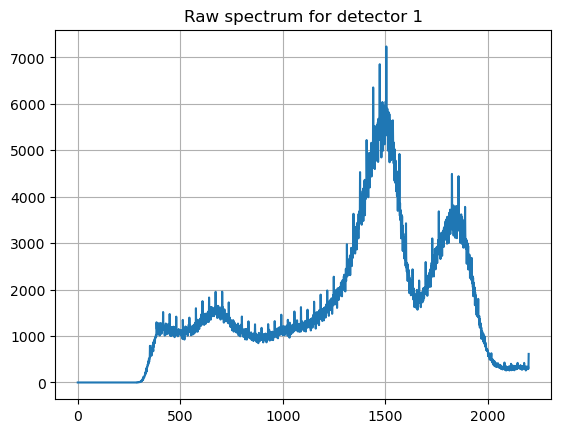

In [9]:
fullspec, _ = np.histogram(data['pha'], bins=pha_bins)
plt.figure()
plt.plot(pha_bins[:-1], fullspec)
plt.grid()
plt.title("Raw spectrum for detector {}".format(detid))


In [12]:
# find global gain and offset

# am_reg = [750, 1200]
# pha_am, err_pha_am = fitpeak(pha_bins[:-1], fullspec, am_reg)
eu1_reg = [1000, 1700]
pha_eu1, err_pha_eu1 = fitpeak(pha_bins[:-1], fullspec, eu1_reg)
eu2_reg = [1600, 2000]
pha_eu2, err_pha_eu2 = fitpeak(pha_bins[:-1], fullspec, eu2_reg)
all_lines = [59.5, 86.5, 105.3]

Resolution is  0.14877513931626174
Resolution is  0.2413365065810317


In [13]:
#plt.vlines([pha_am, pha_eu1, pha_eu2], 0, 35000)
popt, _ = curve_fit(pha2en, [pha_am, pha_eu1, pha_eu2], all_lines, p0 = [0.3, 0], sigma=[err_pha_am, err_pha_eu1, err_pha_eu2])
detector_gain = popt[0]
detector_offset = popt[1]
print("Detector gain = {}, offset = {}".format(detector_gain, detector_offset))
full_energies = pha2en(pha_bins, detector_gain, detector_offset)


Detector gain = 0.052779812742988666, offset = 9.231190218283626


In [14]:
pixphabins = np.arange(0, 2200, 1)
plot_in_func = False
plot_in_loop = False
nrows, ncols = 3, 3
print_pixel_numbers = False
print_pixel_details = False
pixgains = np.zeros(256)
pixoffsets = np.zeros(256)
if (plot_in_func or plot_in_loop): plt.figure()

for pixel in range(255):
    sel = data[data['pixid'] == pixel]
    if print_pixel_numbers: print("Pixel {}, {} counts".format(pixel, len(sel)))
    pixelspec, _ = np.histogram(sel['pha'], bins=pixphabins)
    if (plot_in_func or plot_in_loop): plt.subplot(nrows, ncols, (pixel+1) % (nrows * ncols))
    pixgain, pixoffset = refine_gain_offset(pixphabins[:-1], pixelspec, detector_gain, detector_offset, plot=plot_in_func, verbose=print_pixel_details)
    pix_energies = pha2en(pixphabins, pixgain, pixoffset)
    if plot_in_func: 
        plt.plot(pixphabins[:-1], pixelspec)
        plt.title("Pixel {}".format(pixel))
    elif plot_in_loop:
        plt.plot(pix_energies[:-1], pixelspec)
        for line in all_lines: plt.axvline(line, color='black')
        plt.title("Pixel {}".format(pixel))
    pixgains[pixel] = pixgain
    pixoffsets[pixel] = pixoffset

/tmp/ipykernel_18055/3656869095.py:23: RuntimeWarning: invalid value encountered in sqrt
  newerr.append(np.sqrt(pcov[0,0]))
/home/suman/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Could not fit gain-offset!
Could not fit gain-offset!
Could not fit gain-offset!
Could not fit gain-offset!


In [15]:
pixphabins = np.arange(0, 2200, 1)
pixphabins.shape

(2200,)

In [16]:
str(infile)[:-5] + ".png"

'/home/suman/tifr/202307011_1531_Eu_on_det1_30000pkts.png'

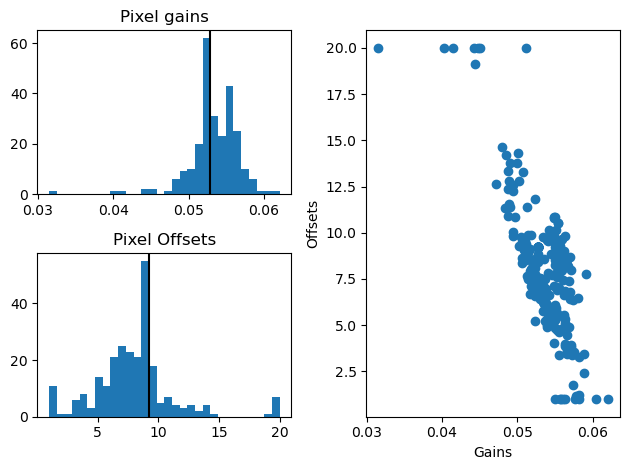

In [17]:
# clean up
bad_go = np.where((pixgains == 0) | (pixoffsets == 0) )
pixgains[bad_go] = detector_gain
pixoffsets[bad_go] = detector_offset

plt.figure()
plt.subplot(2, 2, 1)
plt.hist(pixgains, bins=30)
plt.axvline(detector_gain, color='black')
plt.title("Pixel gains")

plt.subplot(2, 2, 3)
plt.hist(pixoffsets, bins=30)
plt.axvline(detector_offset, color='black')
plt.title("Pixel Offsets")

plt.subplot(1, 2, 2)
plt.scatter(pixgains, pixoffsets)
plt.xlabel("Gains")
plt.ylabel("Offsets")

plt.tight_layout()
#plt.savefig(str(infile)[:-5] + "gain_offset.png")


In [18]:
plot_rebin = False
selfull = (full_energies > 10) & (full_energies < 150) # this is for renormalising after interpolation
final_spectrum = np.zeros(len(full_energies))
len(selfull)

2200

In [19]:
if plot_rebin:
    plt.figure()
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for pixel in range(256):
    pix_energies = pha2en(pixphabins, pixgains[pixel], pixoffsets[pixel])
    sel = data[data['pixid'] == pixel]
    if pixoffsets[pixel] < 1:
        print("Skipping pixel ", pixel)
    if print_pixel_numbers: print("Pixel {}, {} counts".format(pixel, len(sel)))
    pixelspec, _ = np.histogram(sel['pha'], bins=pixphabins[:])
    intfunc = interp1d(pix_energies[:-1], pixelspec, kind='cubic', fill_value='extrapolate')
    intspec = intfunc(full_energies)
    selpix = np.where((pix_energies > 10) & (pix_energies < 150))
    scaling = np.sum(pixelspec[selpix[:-1]]) / np.sum(intspec[selfull])
    #print(scaling)
     #print(len(selpix))
    intspec = intspec * scaling
    if plot_rebin:
        plt.plot(pix_energies[:-1], pixelspec, label="Pixel {}".format(pixel), color=colors[pixel % 5])
        plt.plot(full_energies, intspec, label="Pixel {}".format(pixel), color=colors[pixel % 5], ls='dotted', lw=3)
    final_spectrum = np.nansum([final_spectrum, intspec], axis=0)


/tmp/ipykernel_18055/2099802413.py:14: RuntimeWarning: invalid value encountered in true_divide
  scaling = np.sum(pixelspec[selpix[:-1]]) / np.sum(intspec[selfull])


In [20]:
np.sum(pixelspec[selpix[:-1]])

0

In [21]:
selpix[0].shape

(2185,)

In [22]:
if plot_rebin:
    plt.legend()
    plt.title("Rebinned spectra")


In [23]:
pixelspec.shape, intspec.shape

((2199,), (2200,))

In [29]:
#fitpeak(full_energies, final_spectrum, [50, 70], verbose=True, sigma=2)
fitpeak(full_energies, final_spectrum, [73, 93], verbose=True, sigma=2)
fitpeak(full_energies, final_spectrum, [100, 130], verbose=True, sigma=2)

Resolution is  0.08829949700931256
Resolution is  0.08418619683607775


(116.37225407000737, 0.3370658487518147)

In [30]:
def calculate_fwhm(x, y):
    half_max = max(y) / 2.0
    idx = np.argwhere(np.diff(np.sign(y - half_max)))[0]
    
    left_idx = idx - 1
    right_idx = idx + 1
    
    left_x = x[left_idx]
    right_x = x[right_idx]
    
    fwhm = right_x - left_x
    return fwhm

<IPython.core.display.Javascript object>


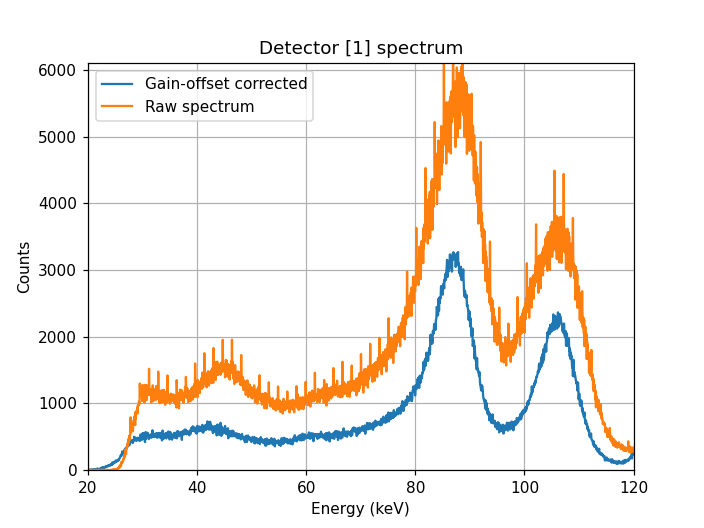

In [34]:
%matplotlib notebook
plt.figure()
plt.plot(full_energies, final_spectrum, label="Gain-offset corrected")
plt.plot(pha2en(pha_bins[:-1], detector_gain, detector_offset), fullspec, label="Raw spectrum")
plt.grid()
plt.xlim(20, 120)
plt.ylim(0,6100)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Detector {} spectrum".format([detid]))
plt.legend()

In [190]:
#plt.savefig("detector_realD{}_detid{}.pdf".format([detid], detid))

In [315]:
plt.savefig(str(infile)[:-5] + "spectra.png")